In [18]:
import numpy as np
import matplotlib.pyplot as plt
import bilby
import pandas as pd
import scipy
import joblib
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
import astropy
import matplotlib.patches as mpatches
from itertools import product
from scipy import stats
from matplotlib.patches import Ellipse
from scipy.stats import gaussian_kde
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset
import arviz as az
import matplotlib
import matplotlib.lines as mlines
from scipy.integrate import quad
from scipy.optimize import root_scalar


In [19]:
SMALL_SIZE = 15+5
MEDIUM_SIZE = 20+5
BIGGER_SIZE = 25+5

plt.rc('font', size=SMALL_SIZE)
plt.rc('axes', titlesize=SMALL_SIZE)
plt.rc('axes', labelsize=MEDIUM_SIZE)
plt.rc('xtick', labelsize=SMALL_SIZE)
plt.rc('ytick', labelsize=SMALL_SIZE)
plt.rc('legend', fontsize=MEDIUM_SIZE)
plt.rc('figure', titlesize=BIGGER_SIZE)

In [20]:
catalog = pd.read_csv('data/mock_galaxy_catalog.txt', delim_whitespace=True, names=['name', 'ra', 'dec', 'z'], skiprows=1)
catalog_dict = {col: catalog[col].values for col in catalog.columns}
HL_samples = joblib.load('output/equal_samples_HL.pkl')
HLV_samples = joblib.load('output/equal_samples_HLV.pkl')

/tmp/ipykernel_1420/4054183599.py:1: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  catalog = pd.read_csv('data/mock_galaxy_catalog.txt', delim_whitespace=True, names=['name', 'ra', 'dec', 'z'], skiprows=1)


In [ ]:
def detector_skymap(detector_delays, measured_delays, sigmas):
    """
    Calculate the masks for each detector based on the measured delays and sigmas, and combine them to get the intersection.
    Args:
        detector_delays (np.ndarray): Array of time delays for each detector.
        measured_delays (list): List of measured delays for each detector.
        sigmas (list): List of standard deviations for each detector.
    Returns:
        masks (np.ndarray): Array of masks for each detector based on the measured delays and sigmas.
        combined (np.ndarray): Combined mask representing the intersection of all detector masks.
    """
    masks = np.zeros(shape=np.array(detector_delays).shape, dtype=bool)
    for i, (detector_delay, measured_delay, sigma) in enumerate(zip(detector_delays.T, measured_delays, sigmas)):
        mask = np.abs(detector_delay.T - measured_delay) <= sigma
        masks[:,:,i] = mask
    combined = masks.T[0].T & masks.T[1].T & masks.T[2].T
    return masks, combined


def plot_maps(masks, combined, equal_samples):
    """
    Plot the RA/Dec posterior distributions for the samples from different detectors, along with histograms and matched filtering contours. Also plot the luminosity distance posterior distributions.
    Args:
        masks (np.ndarray): Masks for each detector based on the measured delays and sigmas.
        combined (np.ndarray): Combined mask representing the intersection of all detector masks.
        equal_samples (list): List of samples from different detectors.
    Returns:
        None: Displays the plots.
    """
    for i, (samples, title) in enumerate(zip(equal_samples, ['HL', 'HLV'])):
        ra = np.linspace(0, 2*np.pi, 1000)
        dec = np.linspace(-np.pi/2, np.pi/2, 1000)
        RA, DEC = np.meshgrid(ra, dec)

        ra_samples = samples[:, 0]
        dec_samples = samples[:, 1]
        ra_median = np.median(ra_samples)
        dec_median = np.median(dec_samples)
        ra_hpd = az.hdi(ra_samples, hdi_prob=0.68)
        dec_hpd = az.hdi(dec_samples, hdi_prob=0.68)

        #RA/Dec posterior plot and contours
        fig = plt.figure(figsize=(30, 8))
        gs = fig.add_gridspec(2, 3, width_ratios=[4, 1, 10], height_ratios=[1, 4], wspace=0.01, hspace=0.05)
        
        #histogram
        ax_hist = fig.add_subplot(gs[1, 0])
        h = ax_hist.hist2d(ra_samples, dec_samples, bins=100, cmap='Oranges')
        ax_hist.set_xlabel('RA (rad)', fontsize=30)
        ax_hist.set_ylabel('Dec (rad)', fontsize=30)
        ax_hist.axvline(ra_median, color='k', linestyle=':')
        ax_hist.axhline(dec_median, color='k', linestyle=':')
        ax_hist.scatter(ra_median, dec_median, color='blue', marker='*', s=500)
        ax_hist.tick_params(axis='both', labelsize=30)
        ax_hist.grid(True)

        #1D RA marginalisation
        ax_ra = fig.add_subplot(gs[0, 0], sharex=ax_hist)
        ax_ra.hist(ra_samples, bins=100, color='grey', density=True)
        ax_ra.set_ylabel('Density', fontsize=30)
        ax_ra.axvline(x=ra_median, color='k', linestyle=':', label='Median')
        ax_ra.tick_params(labelbottom=False, labelsize=30)
        ax_ra.axvspan(ra_hpd[0], ra_hpd[1], color='indigo', alpha=0.3, label='68% CI')
        ax_ra.set_xticklabels([])

        #1D Dec marginalisation
        ax_dec = fig.add_subplot(gs[1, 1], sharey=ax_hist)
        ax_dec.hist(dec_samples, bins=100, color='grey', density=True, orientation='horizontal')
        ax_dec.set_xlabel('Density', fontsize=30)
        ax_dec.axhline(y=dec_median, color='k', linestyle=':')
        ax_dec.tick_params(labelleft=False, labelsize=30)
        ax_dec.set_yticklabels([])
        ax_dec.axhspan(dec_hpd[0], dec_hpd[1], color='indigo', alpha=0.3)
        ax_dec.grid(True)

        #Mollweide projection with matched filtering contours
        ax_moll = fig.add_subplot(gs[:, 2], projection='mollweide')
        ax_moll.grid(True)
        ax_moll.set_xlabel('RA (rad)', fontsize=30)
        ax_moll.set_ylabel('Dec (rad)', fontsize=30)
        ax_moll.tick_params(axis='both', labelsize=30)
        ax_moll.scatter(ra_samples, dec_samples, s=1, color='orange', alpha=1, label='Bayesian samples')
        ax_moll.scatter(ra_median, dec_median, s=100, color='blue', marker='*', label='Median location')
        if i == 0:
            ax_moll.contour(RA, DEC, masks.T[0].T,  colors='grey', linestyles='--', lw=2, zorder=1, label='Matched filtering contour')
        else:
            ax_moll.contour(RA, DEC, combined, colors='grey', linestyles='--', lw=2, zorder=1, label='Matched filtering contour')        

        #adding legend
        handles1, labels1 = ax_ra.get_legend_handles_labels()
        handles2, labels2 = ax_moll.get_legend_handles_labels()

        all_handles = handles1 + handles2
        all_labels = labels1 + labels2
        custom_handles = []
        for handle, label in zip(all_handles, all_labels):
            if label == 'Bayesian samples':
                # For scatter, create a custom Line2D with larger marker
                custom_handle = mlines.Line2D([], [], color='orange', marker='o', linestyle='None',
                                            markersize=10, label=label)
            elif label == 'Matched filtering contour':
                # For contour line
                custom_handle = mlines.Line2D([], [], color='grey', linestyle='--', lw=2, label=label)
            elif label == 'Median':
                custom_handle = mlines.Line2D([], [], color='k', linestyle=':', label=label)
            elif label == '68% CI':
                custom_handle = mlines.Line2D([], [], color='indigo', alpha=0.3, lw=6, label=label)
            elif label == 'Median location':
                custom_handle = mlines.Line2D([], [], color='blue', marker='*', linestyle='None', markersize=10, label=label)
            else:
                continue  # skip unknowns or add other cases as needed
            custom_handles.append(custom_handle)
        custom_handle = mlines.Line2D([], [], color='grey', linestyle='--', lw=2, label='Matched filtering contour')
        custom_handles.append(custom_handle)

        all_labels.append('Matched filtering contour')
        
        fig.legend(custom_handles, all_labels, ncols=5, bbox_to_anchor=[0.9,0], fontsize=30)
        plt.savefig(f'figures/radec_posterior_{title}.png', bbox_inches='tight', dpi=300)

    #luminosity distance posterior plot
    fig, ax = plt.subplots(1, 2, figsize=(20,6), sharey=True)
    for i, samples in enumerate(equal_samples):
        dl_samples = samples[:, 4]
        dl_median = np.median(dl_samples)
        dl_hpd = az.hdi(dl_samples, hdi_prob=0.68)
        
        ax[i].hist(dl_samples, bins=100, color='grey', density=True)
        ax[i].axvline(x=dl_median, color='k', linestyle=':' if i==0 else '-.', label=fr'$D_L = {dl_median:.2f}^{{+{dl_hpd[1]-dl_median:.2f}}}_{{-{dl_median-dl_hpd[0]:.2f}}}$ Gpc')
        ax[i].axvspan(dl_hpd[0], dl_hpd[1], color='indigo', alpha=0.2, label='68% CI' if i==0 else None)
        ax[i].grid(True)
        ax[i].set_xlabel('Luminosity distance $D_L$ (Gpc)')
        ax[i].tick_params(axis='both', labelsize=30)
        
    fig.legend(ncols=3, bbox_to_anchor=[0.8,-0.1])

    ax[0].set_ylabel('Density')

    plt.savefig('figures/dl_posterior.png', bbox_inches='tight', dpi=300)
    plt.show()


def get_kde(samples, catalog_dict, labels=['HL', 'HLV']):
    """
    Perform KDE cross-matching of Bayesian samples with a catalog.
    Args:
        samples (list): List of numpy arrays containing RA/Dec samples from Bayesian inference.
        catalog_dict (dict): Dictionary containing catalog data with keys 'name', 'ra', 'dec', and 'z'.
        labels (list): List of labels for the samples.
    Returns:
        RA (list): List of RA grids for each sample.
        DEC (list): List of DEC grids for each sample.
        densities (list): List of density maps for each sample.
        thresholds (list): List of density thresholds for each sample.
        labels (list): List of labels for the samples.
        matches (list): List of matched catalog DataFrames for each sample.
        samples (list): List of input samples.
    """
    matches = []
    thresholds = []
    densities = []
    RA = []
    DEC = []

    for sample, label in zip(samples, labels):
        kde = gaussian_kde(np.vstack([sample[:,0], sample[:,1]]))

        #grid for evaluation
        ra_grid = np.linspace(sample[:,0].min()-0.1, sample[:,0].max()+0.1, 200)
        dec_grid = np.linspace(sample[:,1].min()-0.1, sample[:,1].max()+0.1, 200)
        RA_grid, DEC_grid = np.meshgrid(ra_grid, dec_grid)
        positions = np.vstack([RA_grid.ravel(), DEC_grid.ravel()])
        density = kde(positions).reshape(RA_grid.shape)

        #sort densities descending, compute cumulative sum
        sorted_density = np.sort(density.ravel())[::-1]
        cumulative = np.cumsum(sorted_density)
        cumulative /= cumulative[-1]  # normalize to 1

        #find density threshold for 90% credible region
        threshold_idx = np.searchsorted(cumulative, 0.9)
        density_threshold = sorted_density[threshold_idx]

        flat = density.flatten()
        idx = np.argsort(flat)[::-1]
        cumulative_density = np.cumsum(flat[idx])
        cumulative_density /= cumulative_density[-1] 
        level = flat[idx][np.searchsorted(cumulative_density, 0.9)]

        gal_dens = kde(np.vstack([catalog_dict['ra'], catalog_dict['dec']]))
        inside = gal_dens >= level

        #filter catalog
        matched_catalog = np.column_stack((
            catalog_dict['name'][inside],
            catalog_dict['ra'][inside],
            catalog_dict['dec'][inside],
            catalog_dict['z'][inside]
        ))
        matched_df = pd.DataFrame(matched_catalog, columns=['name', 'ra', 'dec', 'z'])

        print(f"\nCross-matching {label} samples with the catalog...")
        print(matched_df)
        matches.append(matched_df)
        thresholds.append(density_threshold)
        densities.append(density)
        RA.append(RA_grid)
        DEC.append(DEC_grid)
    return RA, DEC, densities, thresholds, labels, matches, samples


def plot_matches(RA, DEC, densities, thresholds, labels, matches, samples):
    """
    Plot the KDE cross-matching results with 90% credible region contours, catalog points, and Bayesian posterior samples.
    Args:
        RA (list): List of RA grids for each sample.
        DEC (list): List of DEC grids for each sample.
        densities (list): List of density maps for each sample.
        thresholds (list): List of density thresholds for each sample.
        labels (list): List of labels for the samples.
        matches (list): List of matched catalog DataFrames for each sample.
        samples (list): List of input samples.
    Returns:
        None: Displays the plots.
    """
    fig, ax = plt.subplots(1, 2, figsize=(25, 10), sharey=True, gridspec_kw={'wspace':0.1})
    for i, (ra_grid, dec_grid, density, threshold, label, df, sample) in enumerate(zip(RA, DEC, densities, thresholds, labels, matches, samples)):
        ax[i].contour(ra_grid, dec_grid, density, levels=[threshold], linewidths=2)
        ax[i].scatter(catalog_dict['ra'], catalog_dict['dec'], s=15, color='gray', label='Catalog')
        ax[i].scatter(sample[:,0], sample[:,1], s=1, color='red', alpha=0.5, label=f'Bayesian samples')
        ax[i].scatter(df['ra'], df['dec'], s=50, color='blue', label=f'Identified stars')
        ax[i].set_xlabel('RA (rad)', fontsize=30)
        # ax[i].set_ylabel('Dec (rad)')
        ax[i].grid()
        ax[i].tick_params(axis='both', labelsize=30)
    ax[0].set_ylabel('Dec (rad)', fontsize=30)
    all_handles, all_labels = ax[0].get_legend_handles_labels()

    #adding lenend
    custom_handles = []
    for handle, label in zip(all_handles, all_labels):
        if label == 'Catalog':
            # For scatter, create a custom Line2D with larger marker
            custom_handle = mlines.Line2D([], [], color='gray', marker='o', linestyle='None',
                                        markersize=10, label=label)
        elif label == 'Bayesian samples':
            # For contour line
            custom_handle = mlines.Line2D([], [], color='red', marker='o', linestyle='None',
                                        markersize=10, label=label)
        elif label == 'Identified stars':
            custom_handle = mlines.Line2D([], [], color='blue', marker='o', linestyle='None',
                                        markersize=10, label=label)
        else:
            continue  # skip unknowns or add other cases as needed
        custom_handles.append(custom_handle)

    custom_handles.append(mlines.Line2D([], [], color='black', linestyle='-', lw=1, label='90% credible region'))
    all_labels.append('90% credible region')
        
    fig.legend(custom_handles, all_labels, bbox_to_anchor=(0.98, 0), ncol=4, fontsize=35)

    #creating inset for zoomed view
    axins = zoomed_inset_axes(ax[1], zoom=10)

    #repeat plot
    axins.contour(RA[1], DEC[1], densities[1], levels=[thresholds[1]], colors='black', linewidths=3)
    axins.scatter(catalog_dict['ra'], catalog_dict['dec'], s=15, color='gray')
    axins.scatter(samples[1][:, 0], samples[1][:, 1], s=1, color='red', alpha=0.5)
    axins.scatter(matches[1]['ra'], matches[1]['dec'], s=100, color='blue')

    #range
    x1, x2 = 2.18, 2.45  # RA range (rad)
    y1, y2 = -1.12, -1.25  # Dec range (rad)
    axins.set_xlim(x1, x2)
    axins.set_ylim(y2, y1)

    axins.set_xticks([])
    axins.set_yticks([])
    axins.set_xticklabels([])
    axins.set_yticklabels([])

    mark_inset(ax[1], axins, loc1=2, loc2=4, fc="none", ec="black")

    plt.savefig('figures/kde_crossmatch.png', bbox_inches='tight', dpi=300)
    plt.show()

def measure_hubble(samples, df):
    """
    Estimates the Hubble constant from the samples and redshift data by using H0= v / D_L, where v is the recession velocity and D_L is the luminosity distance.
    Args:
        samples (np.ndarray): Array of samples containing luminosity distance and redshift data.
        df (pd.DataFrame): DataFrame containing redshift information.
    Returns:
        None: Prints the Hubble constant and its error bounds.
    """
    dl_samples = samples[:, 4] * 1e3  # Convert Gpc to Mpc

    # Extract redshift and convert to recession velocity
    z = float(df['z'].values[0])
    c = 2.99792458e5  # speed of light in km/s
    v = z * c         # Hubble flow velocity

    # Compute Hubble constant and error bounds
    H0_samples = v / dl_samples
    H0_median = np.median(H0_samples)
    H0_hpd = az.hdi(H0_samples, hdi_prob=0.68)
    H0_lower = H0_hpd[0]  
    H0_upper = H0_hpd[1]

    # Calculate errors
    H0_err_low = H0_median - H0_lower
    H0_err_high = H0_upper - H0_median

    print(f"Hubble constant: {H0_median:.2f} km/s/Mpc +{H0_err_high:.2f} -{H0_err_low:.2f} km/s/Mpc")

def measure_hubble_2(samples, df):
    """
    Estimates the Hubble constant from the luminosity distance samples and redshift data by inverting luminosity distance equation. Assumes a flat Lambda-CDM cosmology.
    
    Args:
        samples (np.ndarray): Array of samples containing luminosity distance and redshift data.
        df (pd.DataFrame): DataFrame containing redshift information.
    Returns:
        None: Prints the Hubble constant and its error bounds.
    """
    # cosmological parameters
    Omega_m = 0.27
    Omega_L = 0.73
    Omega_rel = 8.24e-5
    c = 2.99792458e5  # speed of light in km/s

    def E(z, Omega_m=Omega_m, Omega_L=Omega_L, Omega_rel=Omega_rel):
        return np.sqrt(Omega_m * (1 + z)**3 + Omega_L + Omega_rel*(1+z)**4)

    def luminosity_distance(z, H0, Omega_m=Omega_m, Omega_L=Omega_L, Omega_rel=Omega_rel):
        integral, _ = quad(lambda zp: 1.0 / E(zp, Omega_m, Omega_L, Omega_rel), 0, z)
        DL = (c * (1 + z) / H0) * integral
        return DL

    def inversion(dl_obs, z, Omega_m=Omega_m, Omega_L=Omega_L, Omega_rel=Omega_rel):
        def f(H0):
            return luminosity_distance(z, H0, Omega_m, Omega_L, Omega_rel) - dl_obs

        sol = root_scalar(f, bracket=[20, 200], method='brentq')
        if sol.converged:
            return sol.root
        else:
            raise RuntimeError("Error! Not converged!")
        
    
    dl_samples = samples[:, 4] * 1e3  # Gpc -> Mpc
    
    z = float(df['z'].values[0])
    
    # Invert each D_L sample to get H0 samples
    H0_samples = np.array([inversion(dl, z) for dl in dl_samples])
    
    # Compute median and 68% credible interval
    H0_median = np.median(H0_samples)
    H0_hpd = az.hdi(H0_samples, hdi_prob=0.68)
    
    H0_lower = H0_hpd[0]
    H0_upper = H0_hpd[1]
    H0_err_low = H0_median - H0_lower
    H0_err_high = H0_upper - H0_median
    
    print(f"Hubble constant: {H0_median:.2f} +{H0_err_high:.2f} -{H0_err_low:.2f} km/s/Mpc")

In [22]:
detector_delays, measured_delays, sigmas = joblib.load('output/matched_filtering.pkl')
masks, combined = detector_skymap(detector_delays, measured_delays, sigmas)

/tmp/ipykernel_1420/1966239266.py:85: UserWarning: The following kwargs were not used by contour: 'lw', 'label'
  ax_moll.contour(RA, DEC, masks.T[0].T,  colors='grey', linestyles='--', lw=2, zorder=1, label='Matched filtering contour')
/tmp/ipykernel_1420/1966239266.py:87: UserWarning: The following kwargs were not used by contour: 'lw', 'label'
  ax_moll.contour(RA, DEC, combined, colors='grey', linestyles='--', lw=2, zorder=1, label='Matched filtering contour')


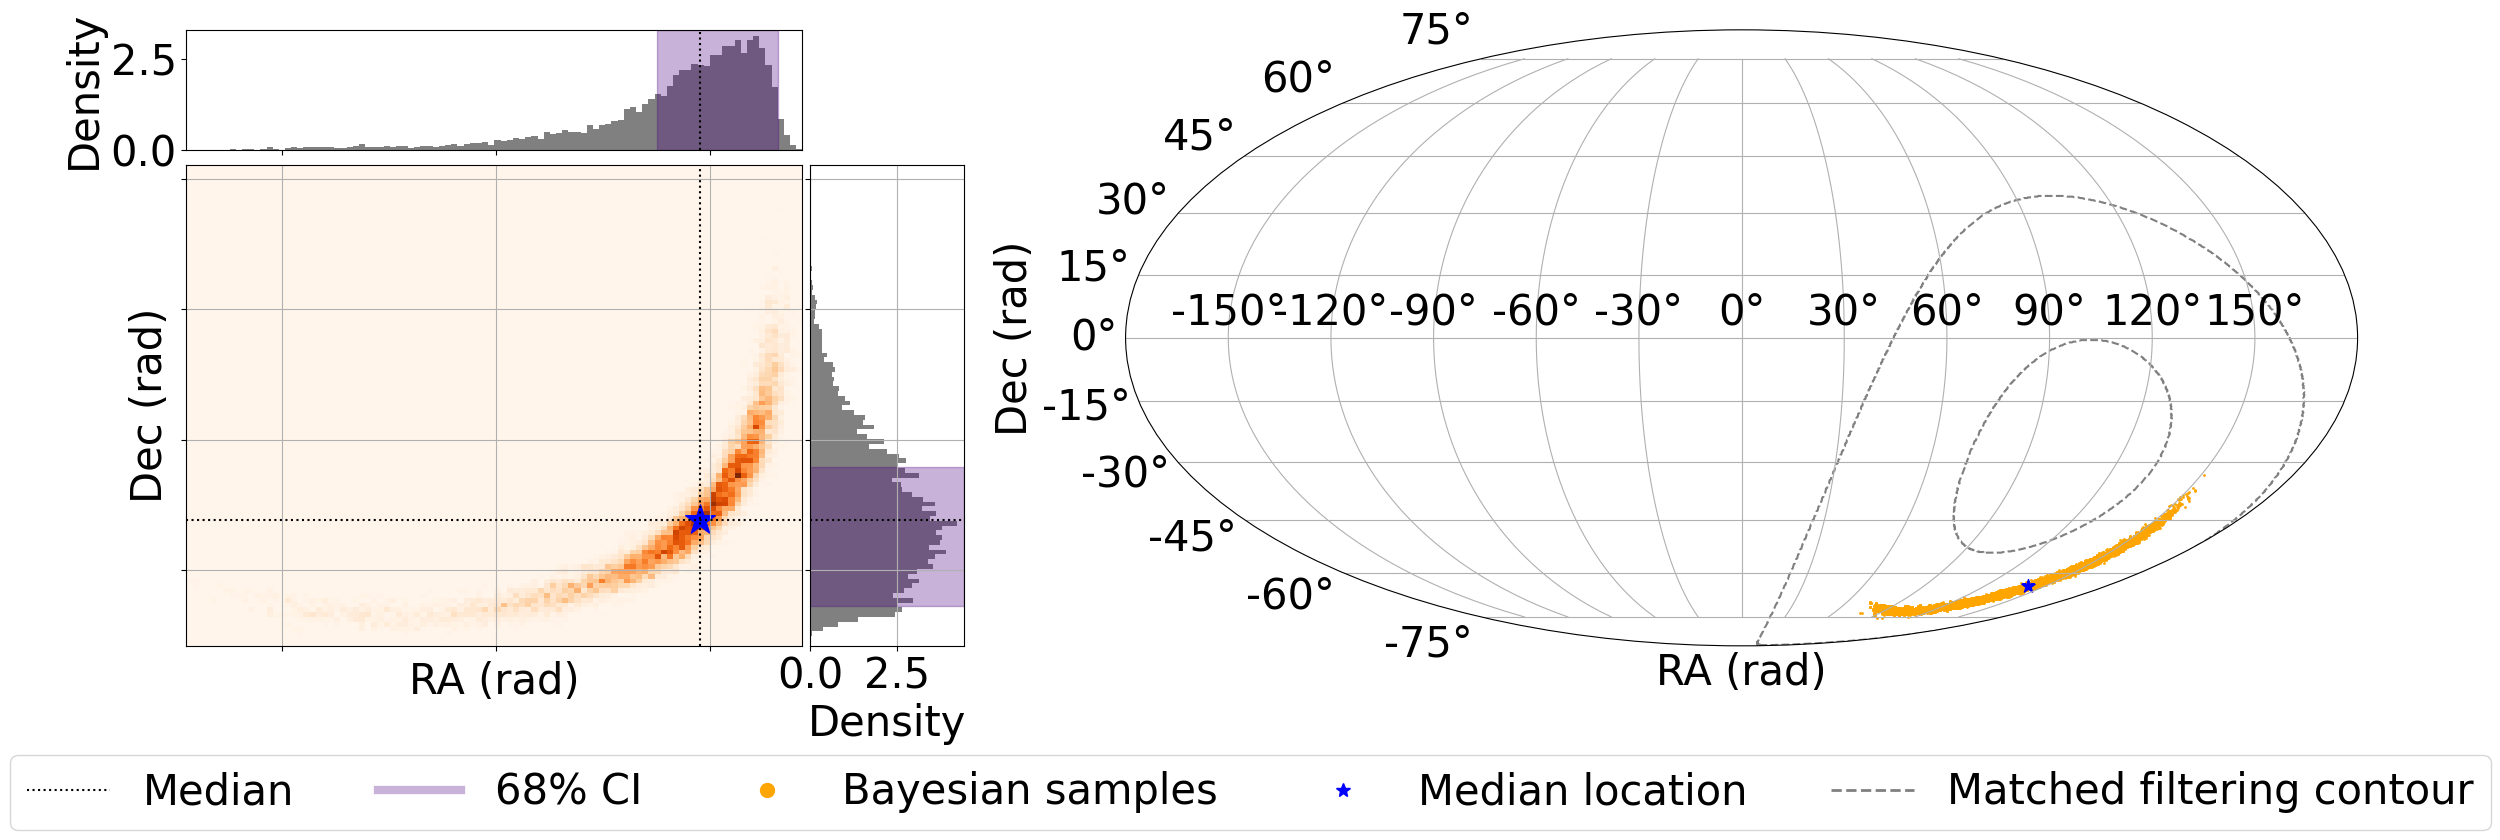

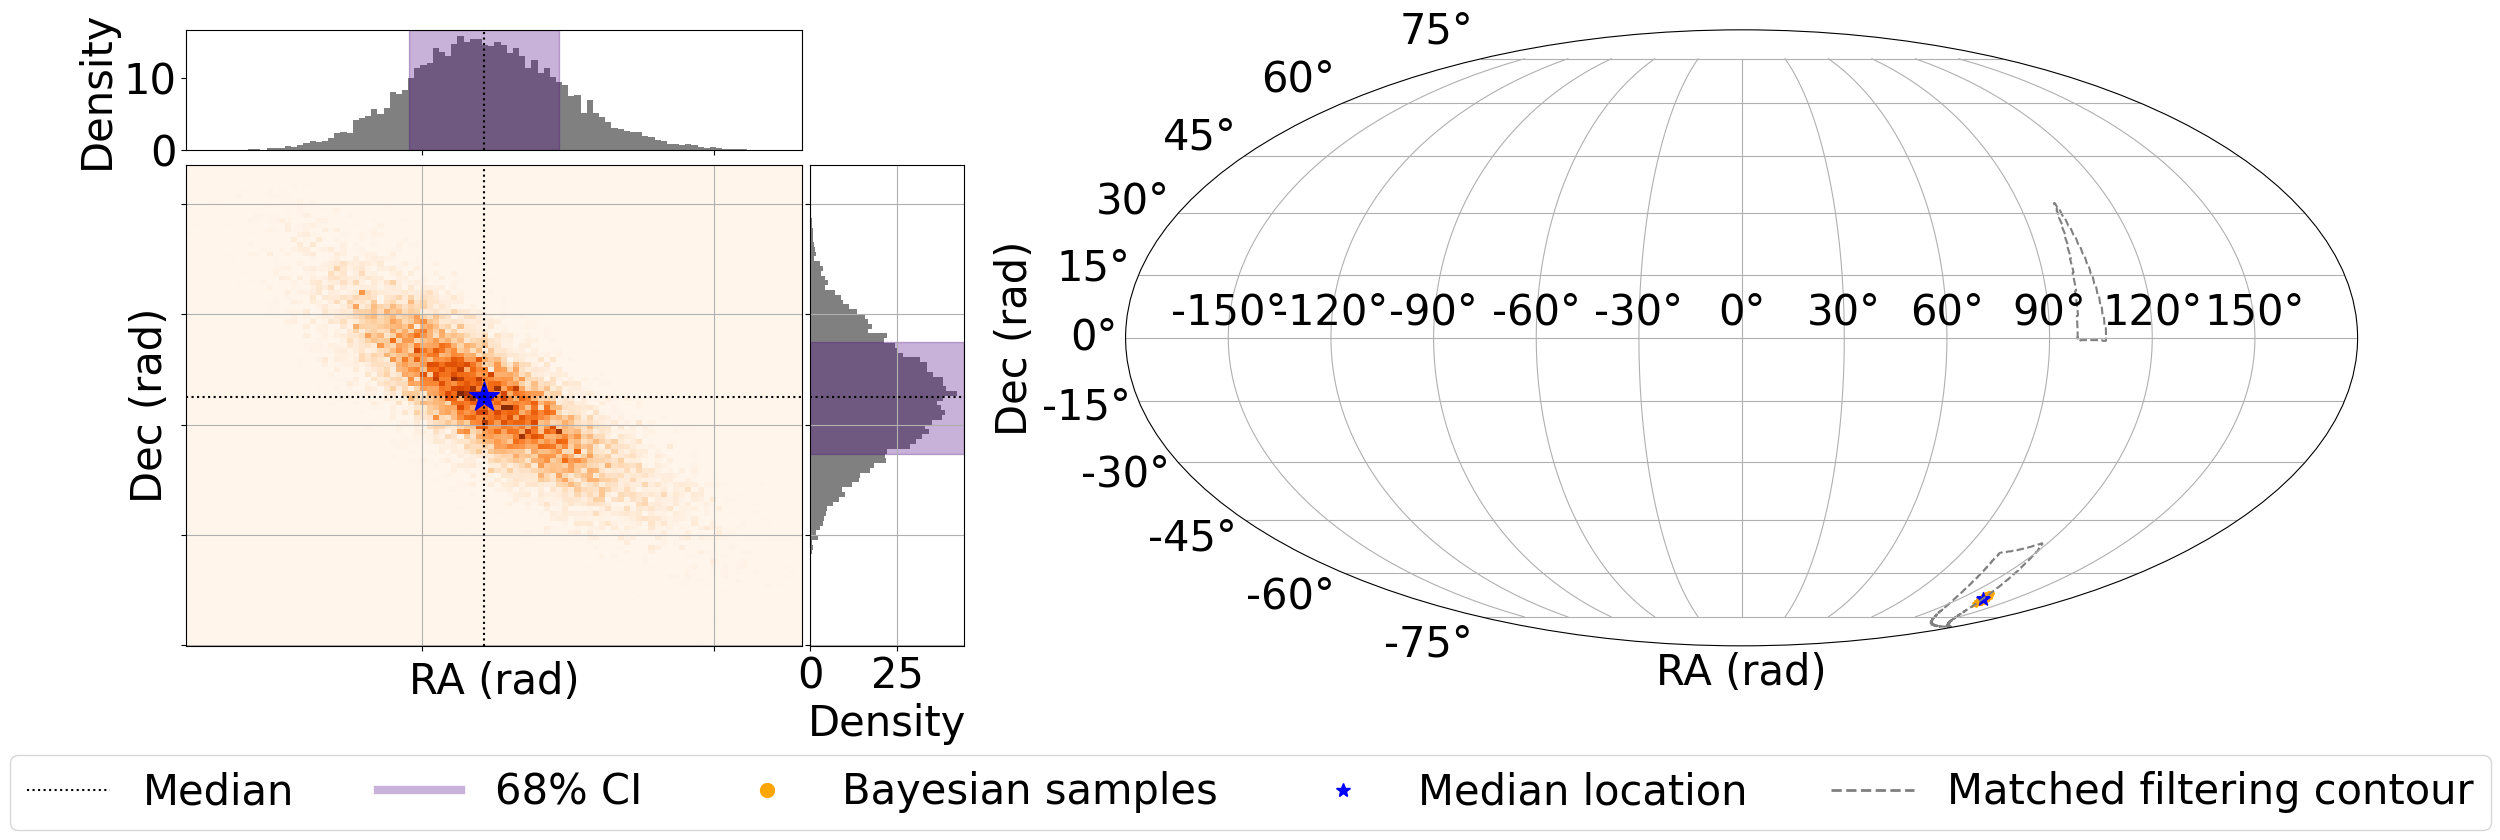

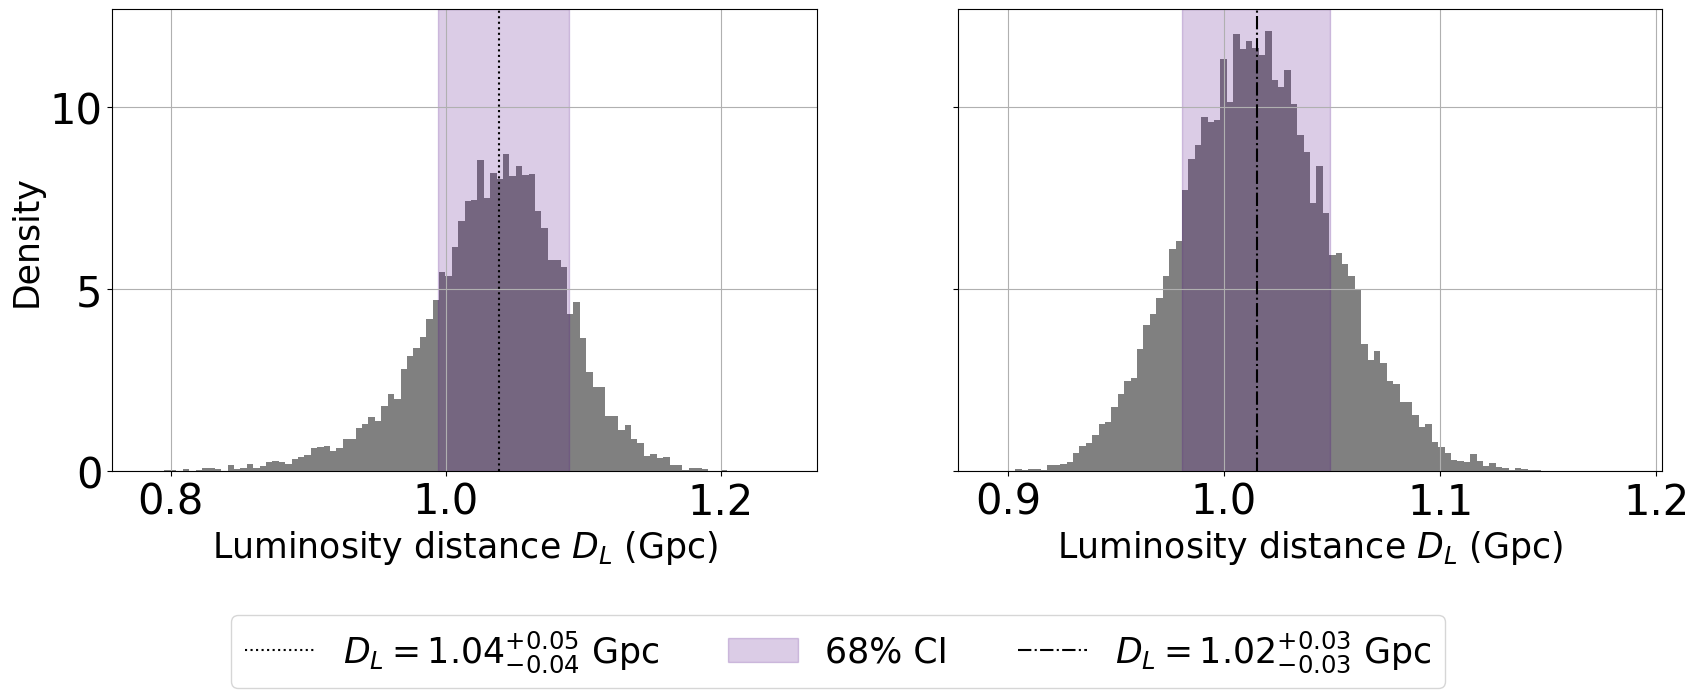

In [23]:
plot_maps(masks, combined, [HL_samples, HLV_samples])

In [24]:
RA, DEC, densities, thresholds, labels, dfs, samples = get_kde([HL_samples, HLV_samples], catalog_dict)


Cross-matching HL samples with the catalog...
          name     ra    dec      z
0  MGC+JGS5HZS  2.543 -0.969  0.797
1  MGC+JN7U119  2.375 -1.211  0.226

Cross-matching HLV samples with the catalog...
          name     ra    dec      z
0  MGC+JN7U119  2.375 -1.211  0.226


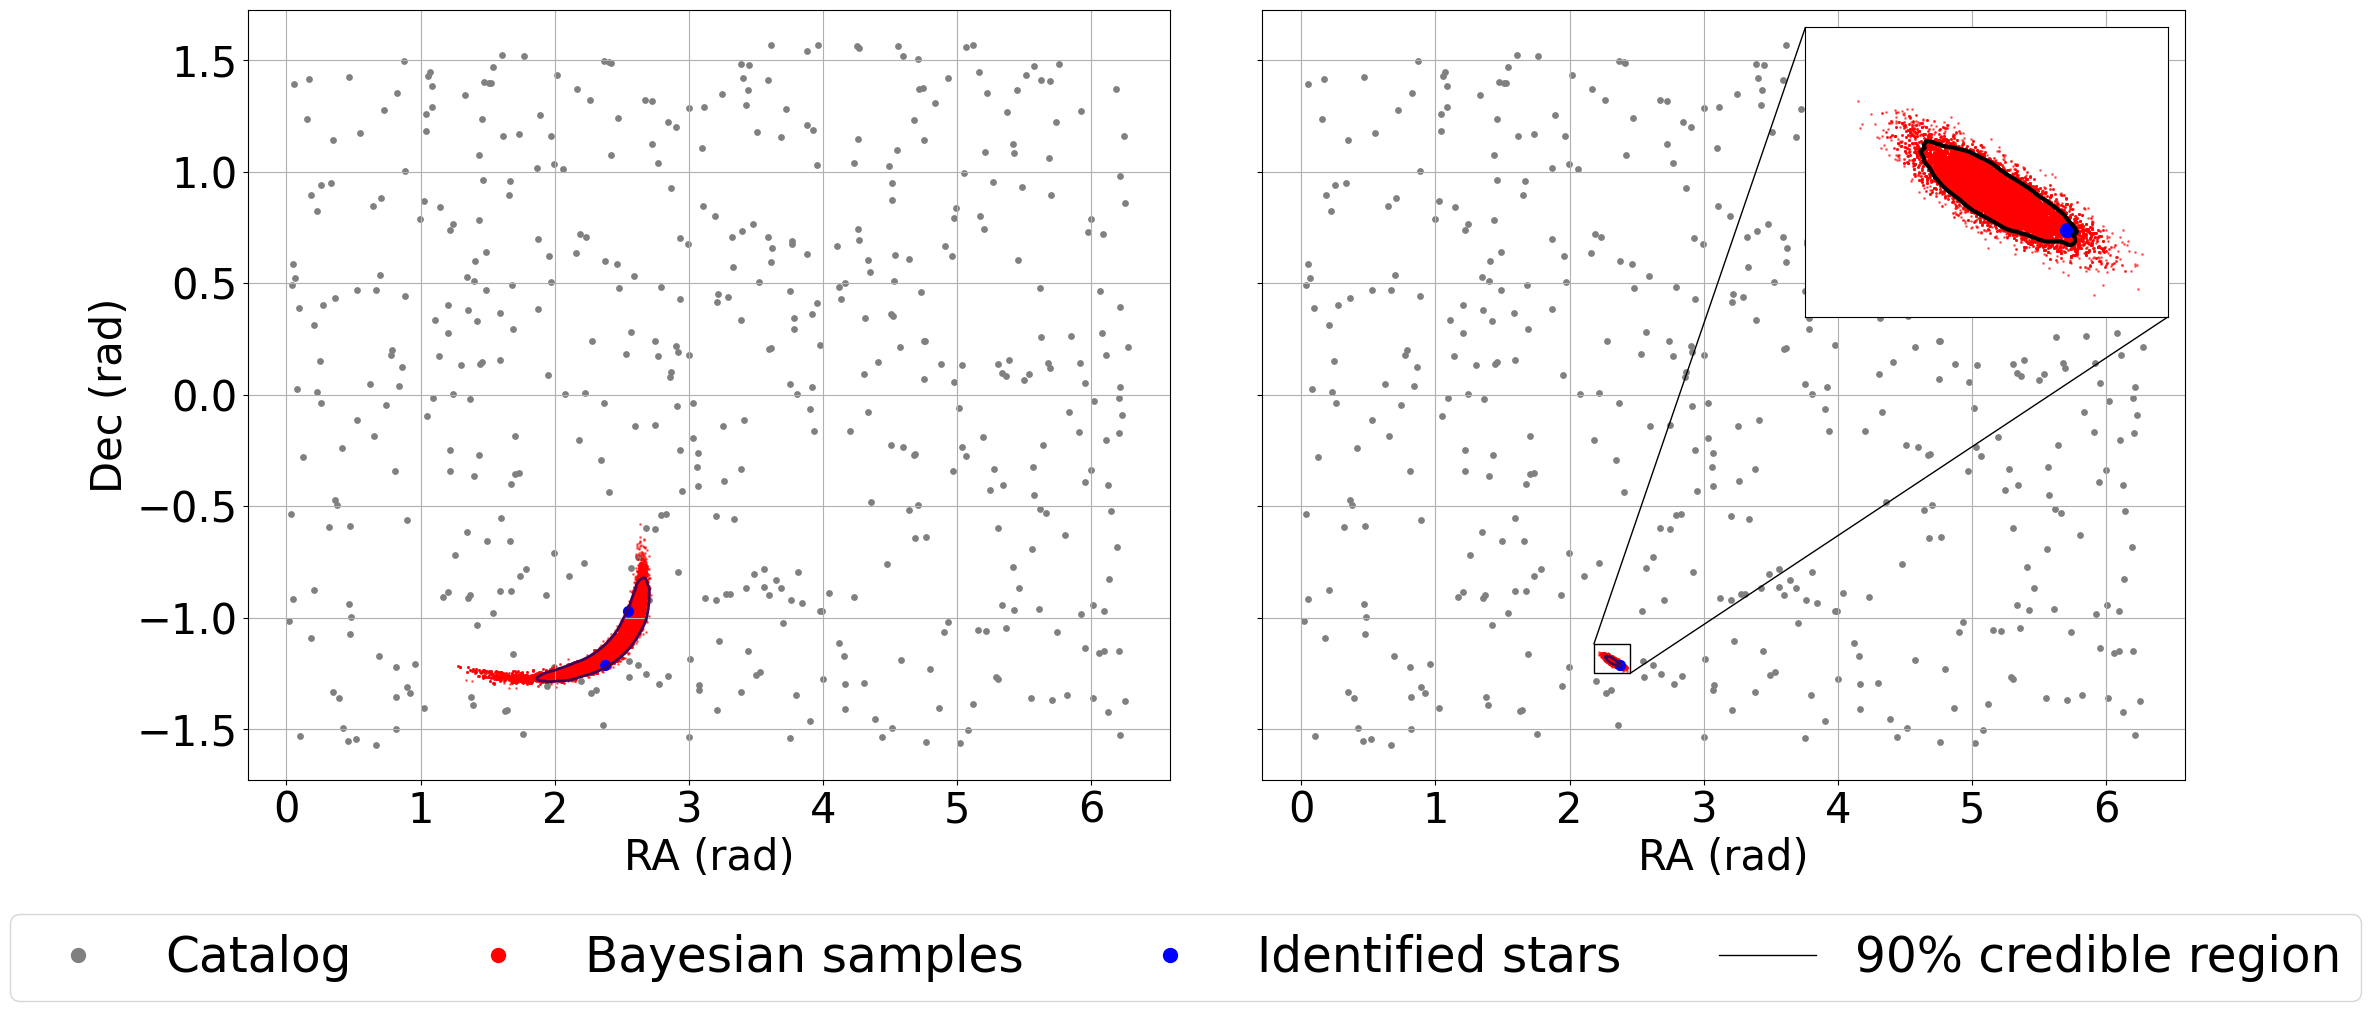

In [25]:
plot_matches(RA, DEC, densities, thresholds, labels, dfs, samples)

In [26]:
measure_hubble(HLV_samples, dfs[1])

Hubble constant: 66.75 km/s/Mpc +2.33 -2.15 km/s/Mpc


In [27]:
measure_hubble_2(HLV_samples, dfs[1])

Hubble constant: 77.91 +2.72 -2.51 km/s/Mpc
